# This is a notebook for querying the merged TS instance for the 1.0.0 Beacon release.
* You can run each cell individually by pressing "shift + enter".
* For more information, questions, bugs, please contact us on Slack:
    + https://join.slack.com/t/beacontechnic-wwa5548/shared_invite/zt-2dp1vv56r-tj_KFac0sAKNuAgUKPPDRg.

#### In order to get access to the Beacon endpoint, you need to fill in your unique personal token between the " " in the cell below.

In [ ]:
Token = " "

#### Install the following packages, if you have not already installed them in your environment:
* pip install requests
* pip install xarray
* pip install ipywidgets
* pip install cartopy
* pip install h5netcdf
* pip install netcdf4
* pip install scipy
* pip install packaging

#### Import the required packages

In [2]:
import requests
import json
import xarray as xr
import datetime
import pandas as pd
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

#### Retrieve the available columns from the Merged TS endpoint
Swagger page here: https://beacon-wb1-ts.maris.nl/swagger/ 

In [3]:
responseinfo = requests.get("https://beacon-wb1-ts.maris.nl/api/query/available-columns", headers = {"Authorization" : f"Bearer {Token}"}) 
params = responseinfo.json()

#### Below you can search through the available columns by entering text between the brackets of search_columns(" ").

In [4]:
def search_columns(search_term):
    search_term = search_term.lower()
    matches = [col for col in params if search_term in col.lower()]
    
    if matches:
        print("Matching columns:")
        for match in matches:
            print(match)
    else:
        print("No matching columns found.")

search_columns("longit") #Enter your search term here

Matching columns:
COMMON_LONGITUDE
COMMON_LONGITUDE_P01
COMMON_LONGITUDE_P06
COMMON_LONGITUDE_STANDARD_NAME
LONGITUDE
LONGITUDE.standard_name
LONGITUDE.units
Longitude


#### You can define here your input parameters 

In [5]:
parameter = "COMMON_TEMPERATURE" #column name 
mindate = "2003-01-01" #yyyy-mm-dd
maxdate = "2003-04-01" #yyyy-mm-dd
minlon = -180
maxlon = 180
minlat = -90
maxlat = 90
mindepth = 0
maxdepth = 10

#### This will create the query body based on your input parameters, you can add other "query_parameters" and "filters" to suit your needs. 
* For more query examples and explanations, you can take a look at https://github.com/maris-development/beacon-blue-cloud.  

In [6]:
def query(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth):
    body = {
        "query_parameters": [
            {
                "column_name": parameter,
                "alias": parameter,
                "skip_fill_values": True
            },
            {
                "column_name": f"{parameter}_UNITS",
                "alias": "Unit"
            },
            {
                "column_name": "COMMON_TIME",
                "alias": "datetime"
            },
            {
                "column_name": f"{parameter}_QC",
                "alias": f"{parameter}_qf"
            },
            {
                "column_name": f"{parameter}_P01",
                "alias": f"{parameter}_P01"
            },
            {
                "column_name": "COMMON_DEPTH",
                "alias": "COMMON_DEPTH"
            },
            {
                "column_name": "COMMON_LONGITUDE",
                "alias": "LONGITUDE"
            },
            {
                "column_name": "COMMON_LATITUDE",
                "alias": "LATITUDE"
            },
            {
                "column_name": "SOURCE_BDI",
                "alias": "Collection"
            }         
        ],
        "filters": [
            {
                "for_query_parameter": "datetime",
                "min": f"{mindate}T00:00:00",
                "max": f"{maxdate}T00:00:00",
                "cast": "timestamp"
            },
            {
              "for_query_parameter": "COMMON_DEPTH",
              "min": mindepth,
              "max": maxdepth
            },
            {
              "for_query_parameter": "LONGITUDE",
              "min": minlon,
              "max": maxlon
            },
            {
              "for_query_parameter": "LATITUDE",
              "min": minlat,
              "max": maxlat
            }
        ],
        "output": {
            "format": "netcdf" 
        }}
    return body

query_body = query(parameter, mindate, maxdate, minlon, maxlon, minlat, maxlat, mindepth, maxdepth)

#### This is the post request that is sent to Beacon with the above specified body.

In [7]:
response = requests.post("https://beacon-wb1-ts.maris.nl/api/query", json.dumps(query_body), headers = {
    "Authorization" : f"Bearer {Token}",
    "Content-type": "application/json"
})

if response.status_code == 204:
    print("No data has been found for your query, please update your input fields above and run the notebook again.")
elif response.status_code != 200:
    print(response.text)

In [8]:
regionname = f"[{minlat},{minlon}],[{maxlat},{maxlon}]" 

if not os.path.exists("./Beacon_V1.0.0_Output"):
    os.makedirs("Beacon_V1.0.0_Output")

open(f"./Beacon_V1.0.0_Output/TS_merged_{parameter}_{regionname}_{mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc", "wb").write(response.content)
df = xr.open_dataset(f"./Beacon_V1.0.0_Output/TS_merged_{parameter}_{regionname}_{mindate}-{maxdate}_[{mindepth}-{maxdepth}m].nc").to_dataframe()
df = df.assign(datetime=pd.to_datetime(df["datetime"])).set_index("datetime").sort_index()
df

,COMMON_TEMPERATURE,Unit,COMMON_TEMPERATURE_qf,COMMON_TEMPERATURE_P01,COMMON_DEPTH,LONGITUDE,LATITUDE,Collection,dataset_id
datetime,,,,,,,,,
2003-01-01,10.200001,degree_C,1.0,SDN:P01::TEMPPR01,1.009575,-4.500000,60.7010,BEACON-CORA-TS,49514.0
2003-01-01,15.899001,degree_C,1.0,SDN:P01::TEMPPR01,0.000000,-88.770000,30.0900,BEACON-CORA-TS,51702.0
2003-01-01,20.399000,degree_C,1.0,SDN:P01::TEMPPR01,0.000000,-95.360000,27.9100,BEACON-CORA-TS,51702.0
2003-01-01,11.500001,degree_C,1.0,SDN:P01::TEMPPR01,1.008759,-10.550600,51.2162,BEACON-CORA-TS,51696.0
2003-01-01,10.900001,degree_C,1.0,SDN:P01::TEMPPR01,1.008963,-5.430900,53.4836,BEACON-CORA-TS,51696.0
...,...,...,...,...,...,...,...,...,...
2003-04-01,29.850000,degree_C,1,SDN:P01::TEMPPR01,1.500000,94.980003,-5.0400,BEACON-WOD,88524.0
2003-04-01,29.170000,degree_C,1,SDN:P01::TEMPPR01,10.000000,-94.949997,3.6200,BEACON-WOD,88526.0
2003-04-01,28.540001,degree_C,1,SDN:P01::TEMPPR01,10.000000,-95.089996,8.1000,BEACON-WOD,88017.0


#### Optionally apply a filter on your parameter for quick removal of outliers. Note that this can also be achieved within your Beacon request by applying a filter on your parameter. 

In [9]:
highbound = 40
lowbound = -2
df = df.loc[(df[f"{parameter}"] < highbound) & (df[f"{parameter}"] > lowbound)]
df

,COMMON_TEMPERATURE,Unit,COMMON_TEMPERATURE_qf,COMMON_TEMPERATURE_P01,COMMON_DEPTH,LONGITUDE,LATITUDE,Collection,dataset_id
datetime,,,,,,,,,
2003-01-01,10.200001,degree_C,1.0,SDN:P01::TEMPPR01,1.009575,-4.500000,60.7010,BEACON-CORA-TS,49514.0
2003-01-01,15.899001,degree_C,1.0,SDN:P01::TEMPPR01,0.000000,-88.770000,30.0900,BEACON-CORA-TS,51702.0
2003-01-01,20.399000,degree_C,1.0,SDN:P01::TEMPPR01,0.000000,-95.360000,27.9100,BEACON-CORA-TS,51702.0
2003-01-01,11.500001,degree_C,1.0,SDN:P01::TEMPPR01,1.008759,-10.550600,51.2162,BEACON-CORA-TS,51696.0
2003-01-01,10.900001,degree_C,1.0,SDN:P01::TEMPPR01,1.008963,-5.430900,53.4836,BEACON-CORA-TS,51696.0
...,...,...,...,...,...,...,...,...,...
2003-04-01,29.850000,degree_C,1,SDN:P01::TEMPPR01,1.500000,94.980003,-5.0400,BEACON-WOD,88524.0
2003-04-01,29.170000,degree_C,1,SDN:P01::TEMPPR01,10.000000,-94.949997,3.6200,BEACON-WOD,88526.0
2003-04-01,28.540001,degree_C,1,SDN:P01::TEMPPR01,10.000000,-95.089996,8.1000,BEACON-WOD,88017.0


#### Plotting of results.

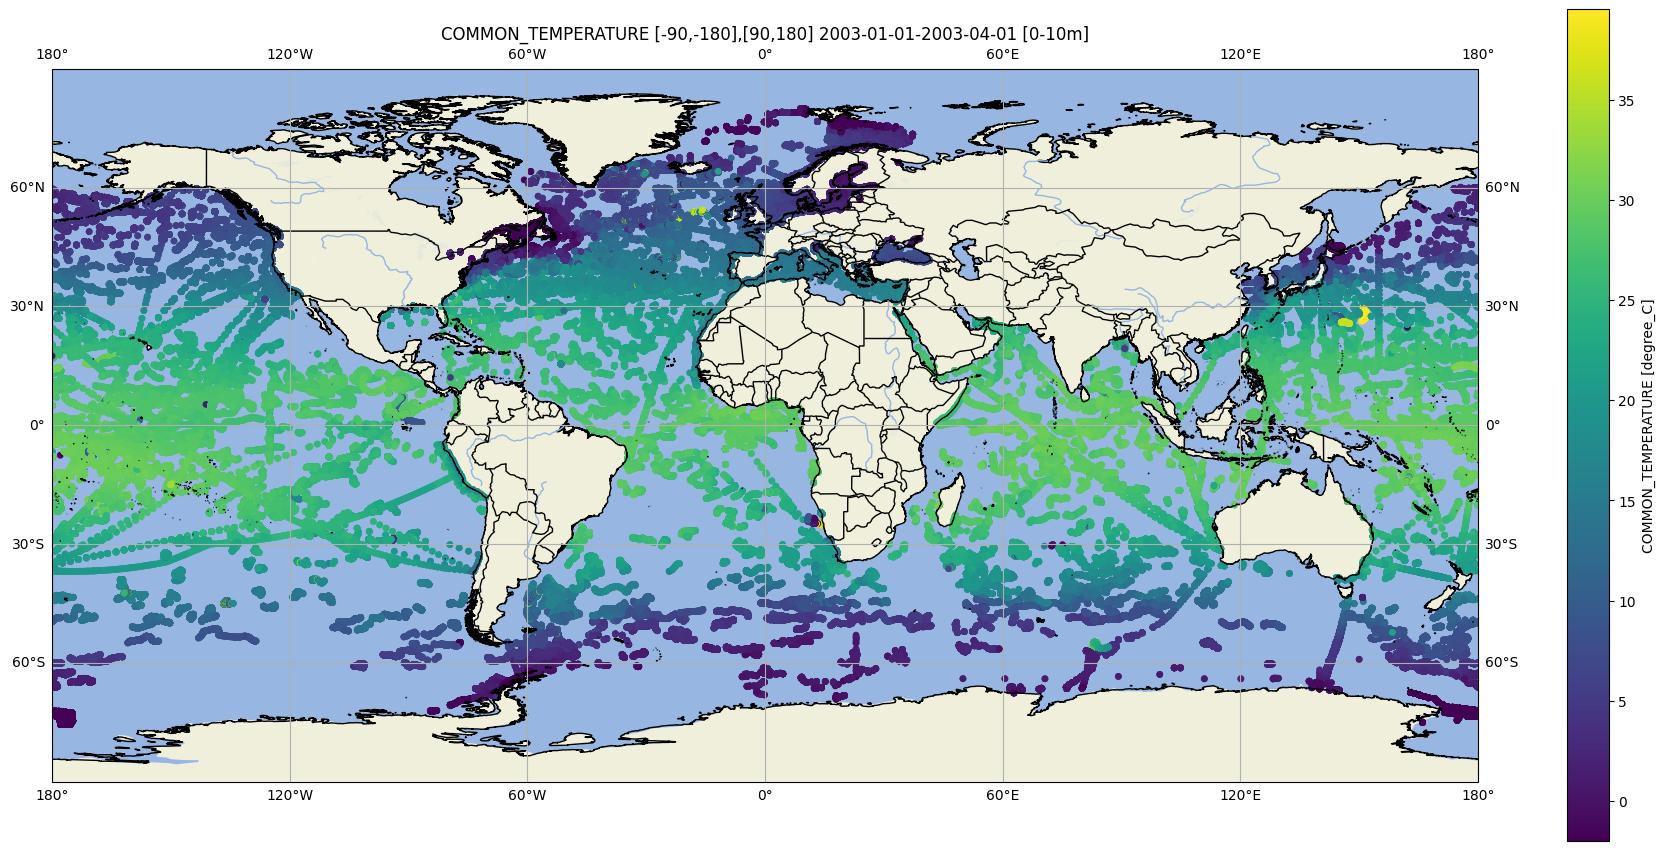

In [10]:
fig = plt.figure(figsize=(23, 18))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())  # (west, east, south, north)

ax.coastlines(resolution="10m")
ax.gridlines(draw_labels=True)

sc = ax.scatter(df["LONGITUDE"], df["LATITUDE"], c=df[parameter], cmap="viridis", s=15, transform=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.RIVERS)     
ax.add_feature(cfeature.BORDERS)   
ax.add_feature(cfeature.LAKES, alpha=0.1) 

cbar = plt.colorbar(sc, ax=ax, orientation="vertical", shrink=0.6, label="Value Set 1")
cbar.set_label(f"{parameter} [{df["Unit"].iloc[0]}]")

plt.title(f"{parameter} {regionname} {mindate}-{maxdate} [{mindepth}-{maxdepth}m]")

plt.show()